In [1]:
import numpy as np
from numpy.random import default_rng
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import preprocessing
from collections import namedtuple
from google.colab import drive
import sys
import torch
from torch.distributions import MultivariateNormal
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
drive.mount('/content/drive/',force_remount=True)
sys.path.insert(0,'/content/drive/My Drive/DeepLearning/')
import os

import time 

Mounted at /content/drive/


In [2]:
cd "/content/drive/My Drive/DeepLearning/Data"

/content/drive/My Drive/DeepLearning/Data


### **Class and Environment Definition**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, net_width):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, net_width)
        self.l2 = nn.Linear(net_width, net_width)
        self.l3 = nn.Linear(net_width, action_dim)

    def forward(self, state):
        n = torch.tanh(self.l1(state))
        n = torch.tanh(self.l2(n))
        return n

    def pi(self, state, softmax_dim = 0):
        n = self.forward(state)
        prob = F.softmax(self.l3(n), dim=softmax_dim)
        return prob

    # def get_dist(self,state):
    #     alpha,beta = self.forward(state)
    #     dist = Beta(alpha, beta)
    #     return dist

class Critic(nn.Module):
    def __init__(self, state_dim,net_width):
        super(Critic, self).__init__()

        self.C1 = nn.Linear(state_dim, net_width)
        self.C2 = nn.Linear(net_width, net_width)
        self.C3 = nn.Linear(net_width, 1)

    def forward(self, state):
        v = torch.relu(self.C1(state))
        v = torch.relu(self.C2(v))
        v = self.C3(v)
        return v


In [4]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()


        self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )
        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        




In [5]:

class StockTradingEnv:
    """
        Specifying the action and observation componenets that would help the agent to learn and move though the environment
        
    """
    def __init__(self,
                 starting_date,
                 ticker,
                 interval,
                 max_training_date,
                 feature_list,
                 max_trading_shares,
                 fee=0.0000, #0.01%,
                 feature_normalisation = False,
                 directory = None):
        
        # Defining the parameters specific to the environment
        
        if directory is None :
            self.df = pd.read_csv(ticker + '_'+str(interval)+'m_analytics.csv')
        else:
            self.df = pd.read_csv(os.path.join(directory,ticker + '_'+str(interval)+'m_analytics.csv'))
        self.df.drop(index=self.df.index[:90],inplace=True)
        self.df = self.df.reset_index(drop = True)
        self.df['date']=pd.to_datetime(self.df['datetime']).dt.date
        self.feature_list = feature_list
        self.max_trading_shares= max_trading_shares
        
        action_list = [i for i in range(max_trading_shares+1)]
        action_list.extend([-i-1 for i in range(max_trading_shares)])
        action_list = sorted(action_list)
  
        self.action_list = action_list

        #setup
        self.fee = fee #Stock trading commission fee per trade
        self.start_date = starting_date
        
        self.current_step = 0
        self.eventlog = [] #eventlog to keep track 
        self.max_training_date = max_training_date



        #To_review

        self.df = self.df[self.df['date']>=datetime.strptime(self.start_date, '%Y-%m-%d').date()].reset_index(drop = True)
        self.training_data = self.df[self.df['date']<datetime.strptime(self.max_training_date, '%Y-%m-%d').date()]
        self.training_data = self.training_data .fillna(0)

        if feature_normalisation == True:
          for feature in self.feature_list :
              max_value  = self.training_data[feature].max()
              min_value  = self.training_data[feature].min()
              self.training_data[feature] =(self.training_data[feature] - min_value)/(max_value-min_value)
        
        self.start_date = self.df['date'].min()
        self.start_price = self.df[self.df['date']==self.start_date]['close'].values[0]

                #used to calculate portfoliovalue
        self.initial_number_shares = 5*self.max_trading_shares
        self.inital_cash_balance = 5*self.max_trading_shares*self.start_price
        self.cash_balance = self.inital_cash_balance
        self.number_shares = self.initial_number_shares

        self.initial_value = self.cash_balance + self.number_shares* self.start_price  # define initial stock price
        self.wallet = [self.initial_value]

        
    def get_state(self,step):
      analytic = np.array(self.training_data[self.feature_list].iloc[step])
      current_price = self.df.iloc[self.current_step]['close']

      if  np.floor((self.cash_balance - self.fee)/current_price)> self.max_trading_shares:
        balanceindicator = 1
      else:
        balanceindicator = ((self.cash_balance - self.fee)/current_price)/self.max_trading_shares

      if self.number_shares > self.max_trading_shares :
        shareindicator = 1
      else:
        shareindicator = self.number_shares / self.max_trading_shares

      
      portfolio = np.array([balanceindicator,shareindicator])
      state = np.concatenate((analytic,portfolio))
      #state_tensor = torch.tensor(state_tensor, device=device).unsqueeze(0)  
      #state = np.array(self.training_data[self.feature_list].iloc[step])
      return state   
        
        
    def step(self,action):
        """
        Move the step and recalculate portfolio Value 
        """
        initialaction = action
        current_price = self.df.iloc[self.current_step]['close']
        reward = 0
        penalty = 0 
        comment = ''
        ## Add condition if buy but enough cash -> hold (bump example) and similarly if sell but no more share -> hold
        if action > 0:
            if current_price * action > self.cash_balance-self.fee :
                action = math.floor(max(self.cash_balance-self.fee,0)/current_price)
                comment = 'Not Enough Cash to Buy action changed to '+str(action)
                penalty = -0.0001
                #print(comment)

            
            if action == 0 :
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
                comment = 'Not Enough Cash to Buy'
                penalty = -0.0005
            else : 
                self.number_shares +=action
                self.cash_balance = self.cash_balance -self.fee - current_price*action
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
              
        if action == 0: 
            self.wallet.append(self.cash_balance + self.number_shares* current_price)

            
        if action < 0:            
            if self.number_shares < abs(action):

                action = self.number_shares*-1
                penalty = -0.0001
                comment = 'Not Enough shares to sell action changed to '+str(action)
                #print(comment)

                
            
            if self.number_shares ==0 :
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
                comment = 'Not Enough Shares to Sell'
                penalty = -0.0005

            else:

                self.number_shares +=action
                self.cash_balance = self.cash_balance -self.fee + current_price*action*-1
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
                '''
                for i in range(abs(action)):
                    bought_price = self.inventory.pop(0)
                    reward = reward +  max(((current_price - bought_price )/bought_price), 0)'''
        
        

        
        #create pandas or array of array which will include = step, action, state, wallet value, reward.     
       
        self.current_step+=1
        
        date = self.df.iloc[self.current_step]['datetime']
        reward = np.clip((self.df.iloc[self.current_step]['close']/current_price)-1,-0.75/100,0.75/100)* action + penalty - self.fee
        reward = reward*10000
        next_state = self.get_state(self.current_step)
        current_price = self.df.iloc[self.current_step]['close']
        self.eventlog.append([self.current_step,date,self.cash_balance + self.number_shares* current_price, self.number_shares,self.cash_balance,current_price,initialaction,action,reward, comment])
        return next_state, reward
        
        
    def display(self):
        print ('Portfolio contains :' + str(self.number_shares ))
        print ('Initial Portfolio Value was : '+ str(self.initial_value))
        print (self.wallet)
        #to add 
        print ('total reward')

    def reset(self):
        self.current_step = 0
        self.cash_balance = self.inital_cash_balance
        self.wallet = [self.initial_value]
        self.inventory = [self.start_price]*self.initial_number_shares
        self.number_shares = self.initial_number_shares

In [6]:
class MemoryBatch():
    def __init__(self, capacity):
        self.capacity = capacity
        
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []

    #just add to memory state,action, state+1,reward in a tensor 
    def push(self, action ,state,probability,reward,state_values ):
      if len(self.actions)<= self.capacity :
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(probability)
        self.state_values.append(state_values)
        self.rewards.append(reward)
    
    def clear(self):
      del self.actions[:]
      del self.states[:]
      del self.logprobs[:]
      del self.rewards[:]
      del self.state_values[:]



### **Input for Training and Analysis**

In [10]:
#initialiase environment 
starting_date = '2019-06-01'
ticker = 'TSLA'
interval = 15
max_training_date = '2022-06-01'
includesentiment =0
if includesentiment == 1 :
  feature_list = [
        'close_return_30_zscore', 'close_return_60_zscore',
        'close_return_90_zscore', 'volume_return_30_zscore',
        'volume_return_60_zscore', 'volume_return_90_zscore',
        'ewm_30_ratio', 'ewm_60_ratio', 'ewm_90_ratio', 'rsi_30', 'rsi_60',
        'rsi_90', 'STOCHk_13_8_8', 'STOCHd_13_8_8','compound',
        'sentiment_30_zscore', 'sentiment_60_zscore', 'sentiment_90_zscore']
else:
    feature_list = [
        'close_return_30_zscore', 'close_return_60_zscore',
        'close_return_90_zscore', 'volume_return_30_zscore',
        'volume_return_60_zscore', 'volume_return_90_zscore',
        'ewm_30_ratio', 'ewm_60_ratio', 'ewm_90_ratio', 'rsi_30', 'rsi_60',
        'rsi_90', 'STOCHk_13_8_8', 'STOCHd_13_8_8']

quarterlydates = ['2019-06-01','2019-09-01','2019-12-01','2020-03-01','2020-06-01',
                  '2020-09-01','2020-12-01', '2021-03-01','2021-06-01',
                  '2021-09-01','2021-12-01','2022-03-01', '2022-06-01']



max_trading_shares = 3

trading = StockTradingEnv(starting_date,ticker,interval, max_training_date, feature_list, max_trading_shares)

(array([0]), <a list of 1 Text major ticklabel objects>)

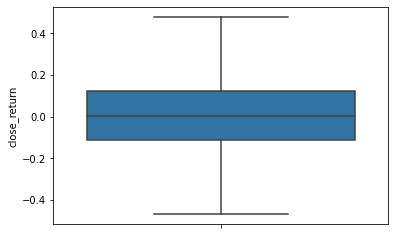

In [9]:
sns.boxplot(y="close_return", data = trading.training_data,showfliers = False)
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

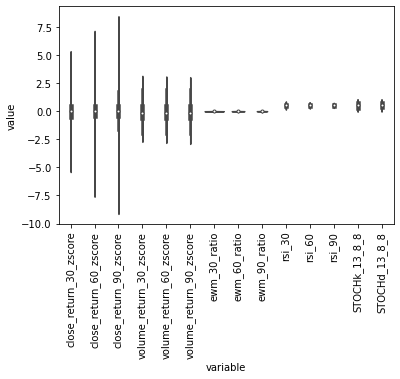

In [10]:
sns.violinplot(x="variable", y="value", data = pd.melt(trading.training_data[feature_list]))
plt.xticks(rotation = 90)

In [8]:
# model parameters
action_size = max_trading_shares*2+1
observation_size = len(feature_list)+2
batchsize = 64
epoch = observation_size*3
net_width = 64
lr = 0.0001
gamma = 0.8
clip = 0.2 
num_episodes = 2000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Training**

In [10]:
for i_dates in range(0,len(quarterlydates)-2):

  starting_date = quarterlydates[i_dates]
  max_training_date = quarterlydates[i_dates+1]
  print(max_training_date)
  
  trading = StockTradingEnv(starting_date,ticker,interval, max_training_date, feature_list, max_trading_shares)
 
  #initialise ppo neural network
  '''actor = Actor( observation_size,action_size, net_width).to(device)
  actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr)
  actorscheduler = ExponentialLR(actor_optimizer, gamma=0.99)
  critic = Critic(observation_size, net_width).to(device)
  critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr)'''
  

  policy = ActorCritic(observation_size, action_size).to(device)
  optimizer = torch.optim.Adam([
                  {'params': policy.actor.parameters(), 'lr': lr},
                  {'params': policy.critic.parameters(), 'lr': lr}])
  policy_old =  ActorCritic(observation_size, action_size).to(device)
  policy_old.load_state_dict(policy.state_dict())
  MseLoss = nn.MSELoss()
  memory = MemoryBatch(batchsize)
  time_step = 0

  start_time = time.time()
  print("Started training at (GMT) : " + datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))
  episode_reward =[]
  lossperepisode =[]
  for i_episode in range(num_episodes):
    trading.reset()
    total_reward = 0
      
    #per episode - fill the memory with every state,i.e every day in our period
    for i in  range(0,len(trading.training_data.index)-2) :

      state= trading.get_state(trading.current_step)
      state_tensor = torch.from_numpy(state).float().to(device)

      #select action without calculating gradient to improve memory. gradient calculated later
      with torch.no_grad():
        action_probs = policy.actor(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_values = policy.critic(state_tensor)

        
      # discrete action space -> Categorical therefore return index from 0 to k-1
      
      action_selected = action-max_trading_shares
      
      #simulate action and get reward 
      next_state, reward = trading.step(action_selected.item())
      total_reward += float(reward)

      memory.push(action,state_tensor,action_logprob,reward,state_values)

      if len(memory.actions) == batchsize :
        #calculate discounted reward to promote long term gain
        rewards = []
        discounted_reward= 0
        for reward in reversed(memory.rewards):
          discounted_reward = reward + (gamma * discounted_reward)
          rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.squeeze(torch.stack(memory.states, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(memory.state_values, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(memory.actions,dim=0)).detach().to(device)
        old_actions_logprob = torch.squeeze(torch.stack(memory.logprobs)).detach().to(device)

        #calculate advantages 
        advantages = rewards.detach() - old_state_values.detach()
        

        
        #evaluate policy
        for i_epoch in range(epoch):
          action_probs = policy.actor(old_states)
          dist = Categorical(action_probs)
          action_logprobs = dist.log_prob(old_actions)
          dist_entropy = dist.entropy()
          state_values = policy.critic(old_states)




          #policy change measure 
          ratios = torch.exp(action_logprobs - old_actions_logprob.detach())
          state_values = torch.squeeze(state_values)

          # clamping the ratio to avoid too unstable diverging policy
          surr1 = ratios * advantages
          surr2 = torch.clamp(ratios, 1-clip, 1+clip) * advantages  
          actor_loss = (-torch.min(surr1, surr2)).mean()
          critic_loss = nn.MSELoss()(state_values, rewards)

          loss = -torch.min(surr1, surr2) + 0.5 * MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
          # take gradient step
          optimizer.zero_grad()
          loss.mean().backward()
          optimizer.step()
            
        # Copy new weights into old policy
        policy_old.load_state_dict(policy.state_dict())
        memory.clear()
    
    print('Episode ', i_episode, ': ', 'reward :',  total_reward, 'actor loss:', actor_loss.detach().cpu(), 'portfolio shares', trading.number_shares,'portfolio cash' ,trading.cash_balance)   
    if i_episode %200 == 0:
      pd.DataFrame(trading.eventlog).to_csv(ticker+'training_eventlog_episode_'+ticker+max_training_date+str(i_episode)+'.csv')
      torch.save(policy.state_dict(), './ppo'+ticker+max_training_date+str(i_episode)+'.pth')
    
    episode_reward.append(total_reward)
    lossperepisode.append(actor_loss.detach().cpu())


  pd.DataFrame({'episode_rewards': episode_reward, 'actor_loss' : episode_reward}).to_csv(ticker+max_training_date+'episodedata.csv')
  pd.DataFrame(trading.eventlog).to_csv(ticker+'training_eventlog_episode_'+ticker+max_training_date+str(i_episode)+'.csv')
  torch.save(policy.state_dict(), './ppo'+ticker+max_training_date+str(i_episode)+'.pth')
  end_time = time.time()
  print("Started training at (GMT) : " + datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))
  print("End training at (GMT) : " + datetime.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S'))





2019-09-01
Started training at (GMT) : 2023-01-18 05:07:06
Episode  0 :  reward : 168.4429787417533 actor loss: tensor(-0.0659) portfolio shares 14 portfolio cash 154.05000000000086
Episode  1 :  reward : -1251.7977060179123 actor loss: tensor(-0.1310) portfolio shares 25 portfolio cash 40.119999999999706
Episode  2 :  reward : 4049.4894378290996 actor loss: tensor(-0.1024) portfolio shares 26 portfolio cash 65.59000000000017
Episode  3 :  reward : 3832.3845081476816 actor loss: tensor(-0.0796) portfolio shares 27 portfolio cash 47.0300000000001
Episode  4 :  reward : 1801.1463534114416 actor loss: tensor(-0.1936) portfolio shares 24 portfolio cash 90.89999999999998
Episode  5 :  reward : 3315.792468524303 actor loss: tensor(-0.1046) portfolio shares 28 portfolio cash 60.62999999999988
Episode  6 :  reward : -1087.8407136710005 actor loss: tensor(-0.1206) portfolio shares 24 portfolio cash 98.47000000000003
Episode  7 :  reward : 2220.4201095940575 actor loss: tensor(-0.1137) portfolio

### **Test Without Sentiment**

In [8]:
#len(quarterlydates)-1
feature_list = [
    'close_return_30_zscore', 'close_return_60_zscore',
    'close_return_90_zscore', 'volume_return_30_zscore',
    'volume_return_60_zscore', 'volume_return_90_zscore',
    'ewm_30_ratio', 'ewm_60_ratio', 'ewm_90_ratio', 'rsi_30', 'rsi_60',
    'rsi_90', 'STOCHk_13_8_8', 'STOCHd_13_8_8']
# model parameters
action_size = max_trading_shares*2+1
observation_size = len(feature_list)+2
batchsize = 64
epoch = observation_size*3
net_width = 64
lr = 0.0001
gamma = 0.8
clip = 0.2 
num_episodes = 2000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(observation_size)

16


In [11]:


alldata = None
for i_dates in range(1,len(quarterlydates)-1):
  mindate = quarterlydates[i_dates]
  maxdate =  quarterlydates[i_dates+1]
  pathtoload = './Model/ppo'+ticker+mindate+'1999.pth'
  policy = ActorCritic(observation_size, action_size).to(device)
  policy.load_state_dict(torch.load(pathtoload, map_location=lambda storage, loc: storage))
  #create evaluating environment 
  
  trading = StockTradingEnv(mindate,ticker,interval, maxdate, feature_list, max_trading_shares)
  for i in  range(0,len(trading.training_data.index)-2) :
    state= trading.get_state(trading.current_step)
    state_tensor = torch.from_numpy(state).float().to(device)
    action_probs = policy.actor(state_tensor)      
    dist = Categorical(action_probs)
    action = dist.sample()
    action_logprob = dist.log_prob(action)
    action_selected = action-max_trading_shares
      
      #simulate action and get reward 
    next_state, reward = trading.step(action_selected.item())
  eventlog = pd.DataFrame(trading.eventlog)
  eventlog.columns = ['step','date','wallet', 'number_shares' ,'cash_balance','price','initialaction','action','reward', 'comment']
  eventlog['cumulativeretun'] =eventlog['wallet']/eventlog['wallet'][0]
  eventlog['cumulativepriceretun'] =eventlog['price']/eventlog['price'][0]
  eventlog['excessreturn'] = eventlog['cumulativeretun'] - eventlog['cumulativepriceretun']
  eventlog['period'] =mindate+'-'+maxdate
  if alldata is None:
    alldata=eventlog
  else:
    alldata=alldata.append(eventlog)


  eventlog.to_csv(ticker+'testing_eventlog'+ticker+maxdate+'.csv')
alldata.to_csv(ticker+'testing_eventlog'+ticker+'alldata.csv')


alldata=alldata.reset_index(drop=True)
alldata['pricereturn'] = alldata['price'].pct_change()


Text(0.5, 1.0, 'TSLA price return distribution')

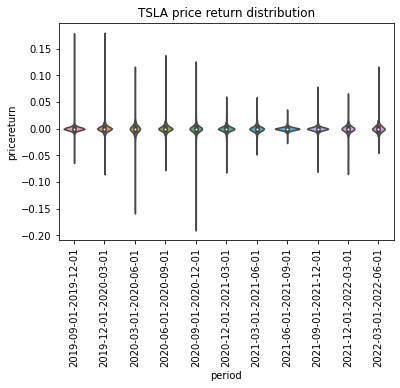

In [12]:

sns.violinplot(x="period", y="pricereturn", data = alldata)
plt.xticks(rotation = 90)
plt.title(ticker+' price return distribution')
#plt.ylim(-0.075,0.075)


### **Test With Sentiment**

In [16]:
feature_list = [
        'close_return_30_zscore', 'close_return_60_zscore',
        'close_return_90_zscore', 'volume_return_30_zscore',
        'volume_return_60_zscore', 'volume_return_90_zscore',
        'ewm_30_ratio', 'ewm_60_ratio', 'ewm_90_ratio', 'rsi_30', 'rsi_60',
        'rsi_90', 'STOCHk_13_8_8', 'STOCHd_13_8_8','compound',
        'sentiment_30_zscore', 'sentiment_60_zscore', 'sentiment_90_zscore']

# model parameters
action_size = max_trading_shares*2+1
observation_size = len(feature_list)+2
batchsize = 64
epoch = observation_size*3
net_width = 64
lr = 0.0001
gamma = 0.8
clip = 0.2 
num_episodes = 2000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(observation_size)

20


In [ ]:
#len(quarterlydates)-1
alldatasent = None
for i_dates in range(1,len(quarterlydates)-1):
  mindate = quarterlydates[i_dates]
  maxdate =  quarterlydates[i_dates+1]
  print (maxdate)
  pathtoload = './Model/ppo_sentiment_'+ticker+mindate+'1999.pth'
  policy = ActorCritic(observation_size, action_size).to(device)
  policy.load_state_dict(torch.load(pathtoload, map_location=lambda storage, loc: storage))
  #create evaluating environment 
  
  trading = StockTradingEnv(mindate,ticker,interval, maxdate, feature_list, max_trading_shares)
  for i in  range(0,len(trading.training_data.index)-2) :
    state= trading.get_state(trading.current_step)
    state_tensor = torch.from_numpy(state).float().to(device)
    action_probs = policy.actor(state_tensor)      
    dist = Categorical(action_probs)
    action = dist.sample()
    action_logprob = dist.log_prob(action)
    action_selected = action-max_trading_shares
      
      #simulate action and get reward 
    next_state, reward = trading.step(action_selected.item())
  eventlog = pd.DataFrame(trading.eventlog)
  eventlog.columns = ['step','date','wallet', 'number_shares' ,'cash_balance','price','initialaction','action','reward', 'comment']
  eventlog['cumulativeretun'] =eventlog['wallet']/eventlog['wallet'][0]
  eventlog['cumulativepriceretun'] =eventlog['price']/eventlog['price'][0]
  eventlog['excessreturn'] = eventlog['cumulativeretun'] - eventlog['cumulativepriceretun']
  eventlog['period'] =mindate+'-'+maxdate
  if alldatasent is None:
    alldatasent=eventlog
  else:
    alldatasent=alldatasent.append(eventlog)


  eventlog.to_csv(ticker+'testing_sent_eventlog'+ticker+maxdate+'.csv')
alldatasent.to_csv(ticker+'testing_sent_eventlog'+ticker+'alldata.csv')


alldatasent=alldatasent.reset_index(drop=True)
alldatasent['pricereturn'] = alldatasent['price'].pct_change()

Text(0.5, 1.0, 'Excess Return Performance')

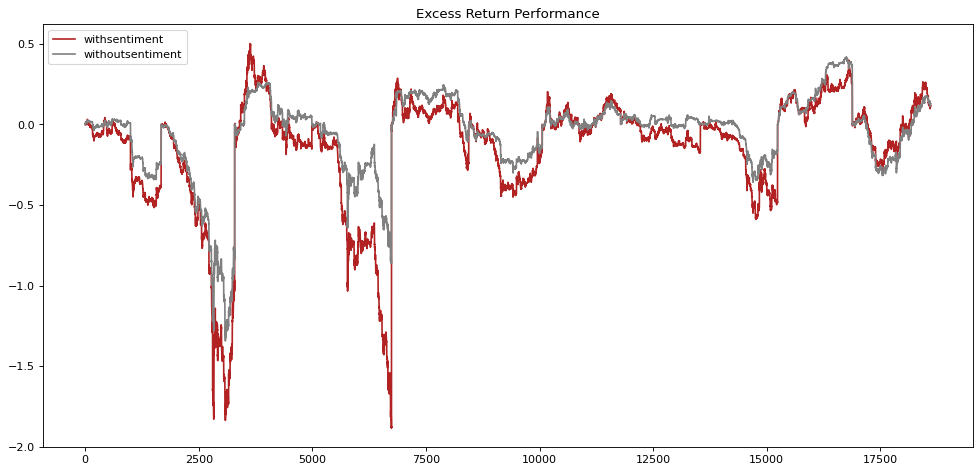

In [28]:
figure(figsize=(15,7), dpi=80)
plt.plot(alldatasent.index,alldatasent['excessreturn'],  color = 'firebrick', label = 'withsentiment')
plt.plot( alldata.index,alldata['excessreturn'], color = 'grey', label = 'withoutsentiment')
plt.legend()
plt.title('Excess Return Performance')
